In [0]:
# !nvidia-smi

In [3]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 645kB 6.2MB/s 
     |████████████████████████████████| 1.1MB 13.9MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
     |████████████████████████████████| 3.8MB 40.8MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/139-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [7]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/aux/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_1.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_2.tar.gz'
!tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_3.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_4.tar.gz'
# !tar -xvf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/aux/fold_5.tar.gz'

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_1/y_train.npy
fold_1/y_train_aux.npy
fold_1/y_valid_mask.npy
fold_1/x_train.npy
fold_1/x_train_aux2.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_2/y_train.npy
fold_2/y_train_aux.npy
fold_2/y_valid_mask.npy
fold_2/x_train.npy
fold_2/x_train_aux2.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_3/y_train.npy
fold_3/y_train_aux.npy
fold_3/y_valid_mask.npy
fold_3/x_train.npy
fold_3/x_train_aux2.npy
fold_4/
fold_4/y_valid.npy
fold_4/x_valid_aux.npy
fold_4/y_train_mask.npy
fold_4/x_train_aux.npy
fold_4/x_valid.npy
fold_4/x_valid_aux2.npy
fold_4/y_valid_aux.npy
fold_4/y_train.npy
fo

# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 4,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": None,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.98e-06


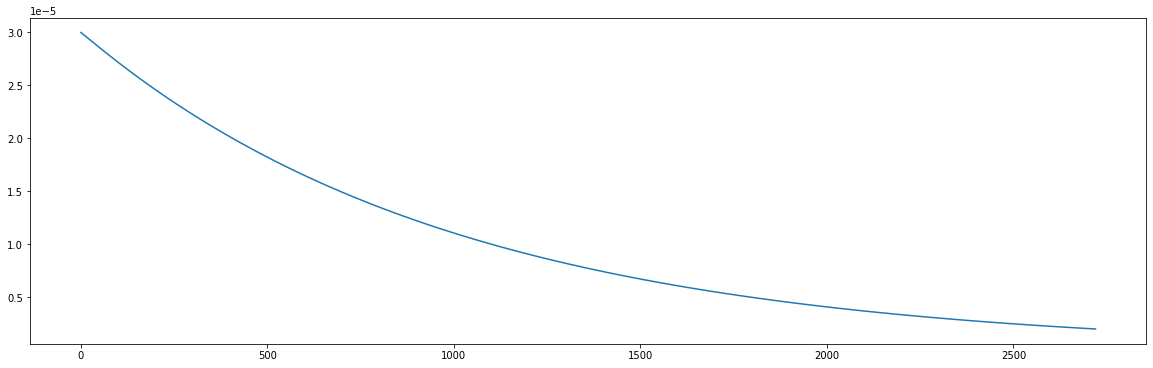

In [30]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
step_size = len(k_fold[k_fold['fold_1'] == 'train']) // config['BATCH_SIZE']
decay = .999

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state)
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state)
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [34]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

# for n_fold in range(config['N_FOLDS']):
for n_fold in range(1, config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_max, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))

    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    # model.load_weights(MODEL_BASE_PATH + model_path)

    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 2
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 282.1s loss: 4.4178 loss_start: 2.2157 loss_end: 2.2021 val_loss: 1.9500 val_loss_start: 0.9996 val_loss_end: 0.9504

EPOCH 2/4
time: 266.5s loss: 4.0159 loss_start: 2.0342 loss_end: 1.9816 val_loss: 1.8774 val_loss_start: 0.9630 val_loss_end: 0.9143

EPOCH 3/4
time: 266.4s loss: 3.9400 loss_start: 1.9929 loss_end: 1.9471 val_loss: 1.9203 val_loss_start: 1.0017 val_loss_end: 0.9186

EPOCH 4/4
time: 266.3s loss: 3.8979 loss_start: 1.9761 loss_end: 1.9218 val_loss: 1.9272 val_loss_start: 0.9799 val_loss_end: 0.9473
Training finished

FOLD: 3
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 280.6s loss: 4.4920 loss_start: 2.2157 loss_end: 2.2763 val_loss: 1.9553 val_loss_start: 0.9842 val_loss_end: 0.9711

EPOCH 2/4
time: 265.9s loss: 4.0321 loss_start: 2.0291 loss_end: 2.0030 val_loss: 1.8624 val_loss_start: 0.9646 val_loss_end: 0.8978

EPOCH 3/4
time: 265.8s loss: 3.9155 loss_start: 1.9752 loss_end: 1.9404

# Model loss graph

Fold: 1


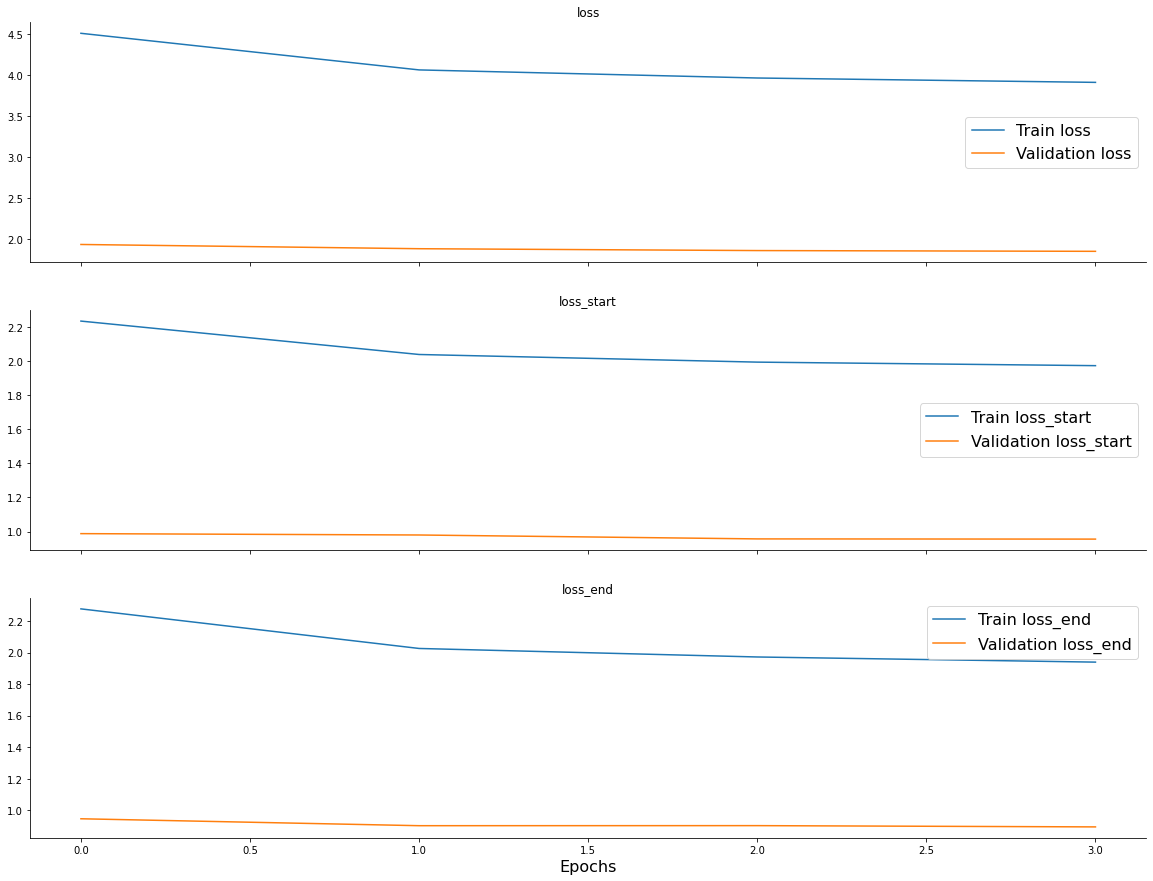

Fold: 2


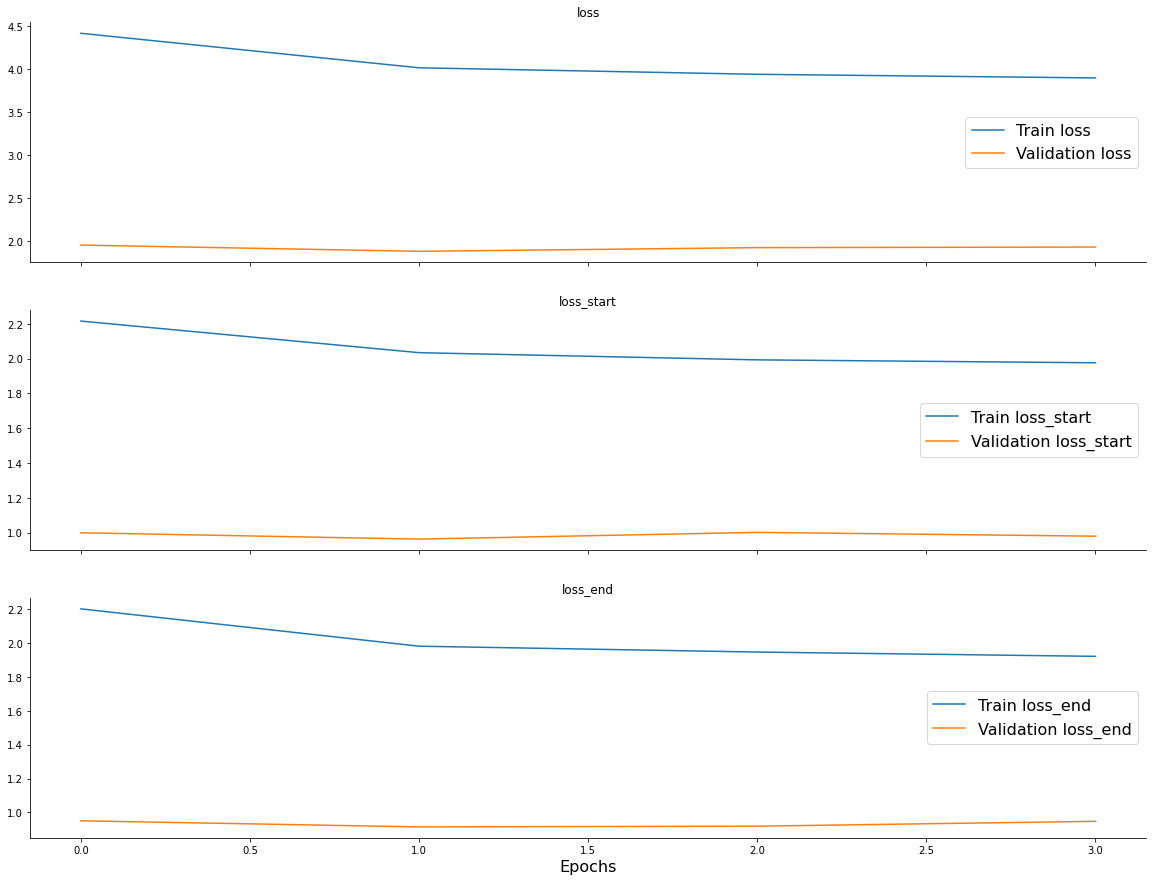

Fold: 3


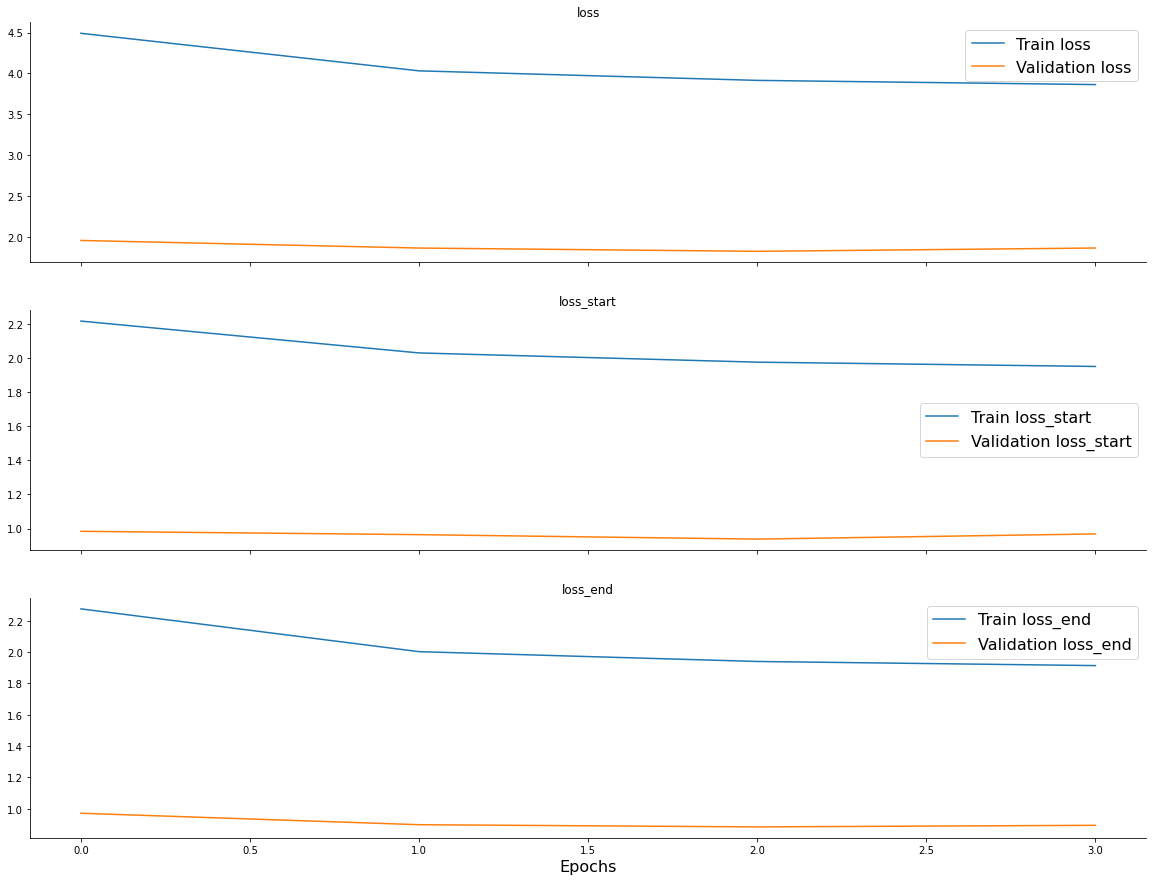

In [35]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [36]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.741126,0.705451,0.035675,0.736507,0.701620,0.736470,0.701786,0.750401,0.712948
Sentiment negative,0.589634,0.519228,0.070407,0.584454,0.504275,0.578707,0.521887,0.605741,0.531520
Sentiment neutral,0.973567,0.972968,0.000599,0.972348,0.973089,0.973469,0.972019,0.974883,0.973795
Sentiment positive,0.577395,0.527686,0.049709,0.568898,0.528729,0.572537,0.514678,0.590749,0.539652
0 <= text wordCnt < 3,0.859821,0.852665,0.007156,0.859848,0.832090,0.853754,0.853201,0.865861,0.872703
3 <= text wordCnt < 10,0.793229,0.764144,0.029085,0.793458,0.754765,0.788723,0.761240,0.797507,0.776428
10 <= text wordCnt < 30,0.709025,0.669976,0.039049,0.702394,0.667627,0.703888,0.666727,0.720794,0.675574
30 <= text wordCnt < 100,0.685722,0.587447,0.098275,0.635031,0.665517,0.718320,0.533550,0.703815,0.563273
0 <= selected text wordCnt < 3,0.696018,0.626351,0.069667,0.703204,0.631363,0.685609,0.627859,0.699241,0.619830


# Visualize predictions

In [37]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,sad,0.500000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,0.166667,bullying,0.500000,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,wow... u just became cooler.,1.000000,wow...,0.200000,wow...,0.200000
